In [1]:
print("init...")
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")
print("init done.")



init...
init done.


In [2]:
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

Данные из предоставленного датасета

            Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-07-23   12873
2020-07-24   13026
2020-07-25   13172
2020-07-26   13249
2020-07-27   13334

[188 rows x 1 columns]


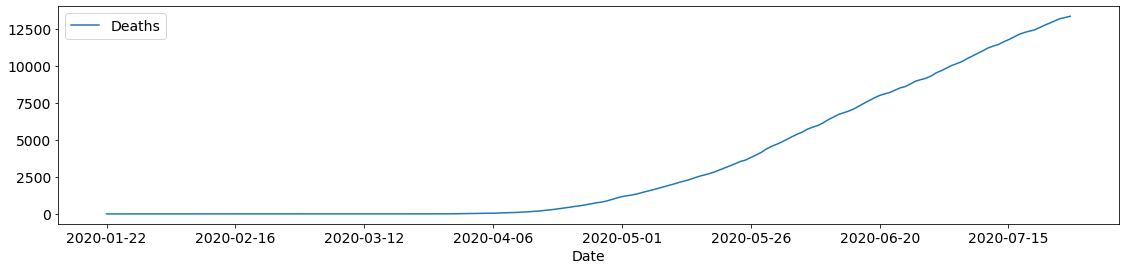

In [3]:
data=pd.read_csv("data/full_grouped.csv")
data=data.loc[data['Country/Region'] == "Russia"]
data.drop("Country/Region",1, inplace=True)
data.drop("WHO Region",1, inplace=True)
y=data.loc[:,["Date","Deaths"]]
y=y.set_index(["Date"])
# y2=y.copy()
# y2=y2[-10:]
# y=y[:-10]
print(y)
# print(y2)
y.plot(figsize=(19,4))
# y2.plot(figsize=(19,4))
plt.show()

Данные из Yandex DataLens

                  Дата  Заражений за день
Дата                                     
03.01.2021  03.01.2021              23845
04.01.2021  04.01.2021              23015
05.01.2021  05.01.2021              23955
06.01.2021  06.01.2021              23902
07.01.2021  07.01.2021              23218
...                ...                ...
28.12.2021  28.12.2021              21751
29.12.2021  29.12.2021              20957
30.12.2021  30.12.2021              20914
31.12.2021  31.12.2021              20482
01.01.2022  01.01.2022              19606

[364 rows x 2 columns]


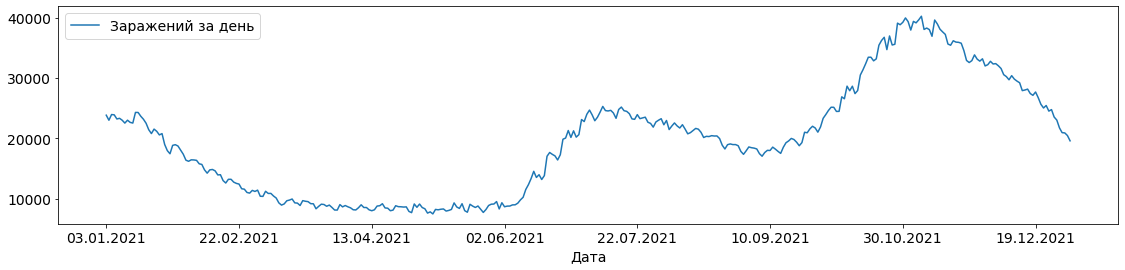

In [4]:
data=pd.read_csv("data/covid.csv", sep=";")
data=data.loc[data['Страна'] == "Россия"]
# data["Дата"]=pd.to_datetime(data["Дата"])
# data.sort_values(by=["Дата"], inplace=True)
data.drop("Страна",1, inplace=True)
# data.plot(figsize=(19,4))
y=data.loc[:,["Дата","Заражений за день"]]
# y=y.set_index(["Дата"])
y.index=y["Дата"]
print(y)
y.plot(figsize=(19,4))
plt.show()

In [5]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [6]:
aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
# aic_miss = pd.DataFrame(np.zeros((6,6), dtype=float))
# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(y["Заражений за день"], order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan
            
        #        # Estimate the model with missing datapoints
        # mod = sm.tsa.statespace.SARIMAX(y2, order=(p,0,q), enforce_invertibility=False)
        # try:
        #     res = mod.fit(disp=False)
        #     aic_miss.iloc[p,q] = res.aic
        # except:
        #     aic_miss.iloc[p,q] = np.nan


In [7]:
print(aic_full,"\n")
aic_filter=np.nan_to_num(aic_full)
i,j=np.where(aic_filter==np.min(aic_filter[np.nonzero(aic_filter)]))
print("min aic[%s][%s]:"%(j[0],i[0]) ,aic_full[j[0]][i[0]])
print("ARIMA(%s,%s)"%(i[0],j[0]))

             0            1            2            3            4  \
0     0.000000  8038.806517  7976.923762  7960.464410  6894.208771   
1  5894.652799  5896.590611  5898.596945  5899.800368  5885.708372   
2  5896.590294  5898.650767  5899.742786  5899.831283  5886.702991   
3  5898.590357  5899.621630  5901.765193  5900.981457  5869.395769   
4  5899.244102  5899.848345  5899.620742  5903.646019  5861.629076   
5  5895.936892  5897.926774  5839.881565  5905.478971  5825.855419   

             5  
0  7956.350283  
1  5882.281918  
2  5813.836386  
3  5777.681541  
4  5744.481804  
5  5777.532723   

min aic[5][4]: 5744.481803886554
ARIMA(4,5)


In [8]:
# print(aic_miss,"\n")
# aic_filter=np.nan_to_num(aic_miss)
# i,j=np.where(aic_filter==np.min(aic_filter[np.nonzero(aic_filter)]))
# print("min aic[%s][%s]:"%(j[0],i[0]) ,aic_miss[j[0]][i[0]])
# print("ARIMA(%s,%s)"%(i[0],j[0]))

In [12]:
mod = sm.tsa.statespace.SARIMAX(y["Заражений за день"], order=(i[0],0,j[0]))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:      Заражений за день   No. Observations:                  364
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -2860.843
Date:                Fri, 28 Jan 2022   AIC                           5741.686
Time:                        14:10:50   BIC                           5780.657
Sample:                             0   HQIC                          5757.175
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          3.2286      0.015    209.109      0.000       3.198       3.259
ar.L2         -4.4498      0.035   -125.383      0.000      -4.519      -4.380
ar.L3          3.2006      0.035     92.148      0.0

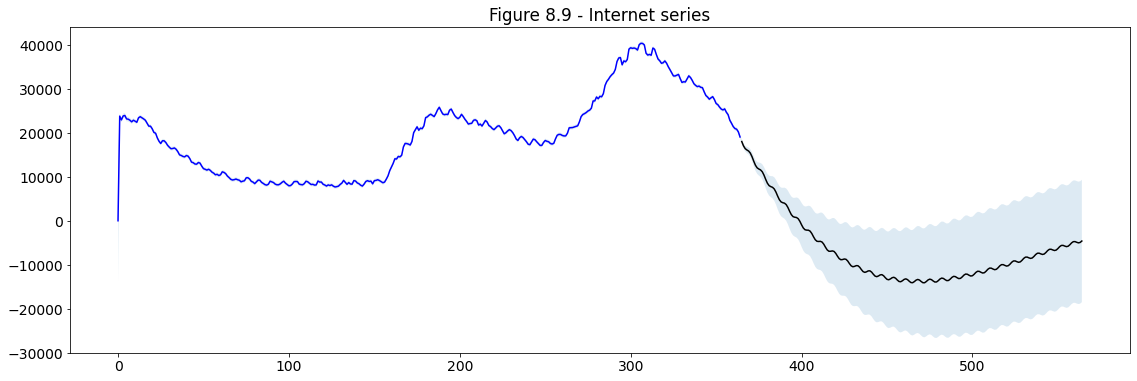

,lower Заражений за день,upper Заражений за день
0,-14123.690729,14123.690729
1,23290.076883,24365.357674
2,22430.960053,23505.563064
3,23330.764501,24397.517557
4,23438.061460,24504.463230
...,...,...
560,-18681.293432,9191.586003
561,-18841.469054,9032.250672
562,-18969.844012,8904.530912
563,-18880.141309,8994.639158


In [10]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 200
predict = res.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)
# print(predict_ci.get("lower Deaths").values)
# Graph
fig, ax = plt.subplots(figsize=(19,6))
# ax.xaxis.grid()
# ax.plot(y, 'k.')
# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'blue')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'black')
ax.fill_between(idx, predict_ci.get(predict_ci.columns[0]).values, predict_ci.get(predict_ci.columns[1]).values, alpha=0.15)
ax.set(title='Figure 8.9 - Internet series')
plt.show()
x=predict.predicted_mean[-nforecast:]
x
predict_ci